The code implmentation for fine-tuning the GPT-2 model is inspired by these 2 blog posts https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html and 
https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/

My code follows the regular steps to fine-tuned a PyTorch model which is similar to any other PyTorch model training implementation. The only difference is the use of loss function, specific optimizer, scheduler and initial hyper parameters that I emplployed from the above links. I also used different deocding functions from huggingface to see the outputs of the generative model.

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 182 kB 71.2 MB/s 
     |████████████████████████████████| 7.6 MB 23.6 MB/s 


Import essential modules and packages

In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split


from tqdm import tqdm, trange

from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

torch.manual_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Since we are running the code on google colab, We load the data from google drive. To run this code, please upload "train.csv" and "vaild.csv" files to your google drive and change the path to access the file on your drive accordingly. 

In [11]:
drive.mount('/content/gdrive')
train = '/content/gdrive/MyDrive/data/train_emails.csv'
valid = '/content/gdrive/MyDrive/data/valid_emails.csv'

df_train = pd.read_csv(train)
df_valid = pd.read_csv(valid)




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
emails = pd.concat([df_train, df_valid])

In [5]:
phish = emails.loc[emails['label'] == 1]
legit = emails.loc[emails['label'] == 0]

In [8]:
texts = phish['text']

We just need the text to generate the phishing emails

Tokenize the emails to get an idea about emails distrubution based on the number of tokens. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


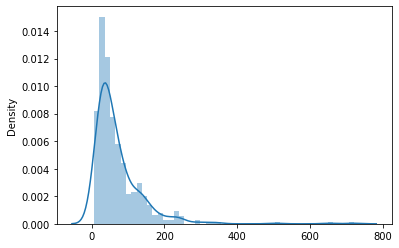

In [9]:
text_lengths = []

for text in texts:
  tokens = nltk.word_tokenize(text)
  text_lengths.append(len(tokens))

text_lengths = np.array(text_lengths)
sns.distplot(text_lengths)


In [10]:
np.mean(text_lengths)

71.52446183953033

GPT-2

In [ ]:
# Load GPT2 tokenizer from pretrained model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2',pad_token='<|pad|>')

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Test the tokenizer
encodings_dict = tokenizer('This is a test', truncation=True, max_length=768, padding="max_length")
encodings_dict

{'input_ids': [1212, 318, 257, 1332, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 5025

In [ ]:
# It will not work with batch size more than 2, GPU will go out of memory on google colab
batch_size = 2

Creating dataset class is a typical step before transfer data to pytorch DataLoaders 

In [ ]:
class GPT2Emails(Dataset):
  # we need init function to initialize the class
  def __init__(self, text_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attention_masks = []

    for text in text_list:

      # each email is tokenaized and the input_ids and attention mask are saved in different list
      encodings_dict = tokenizer(text, truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attention_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, index):
    return self.input_ids[index], self.attention_masks[index] 


Creat a GPT2Emails object and pass emails, tokenizer and max length

In [ ]:
dataset = GPT2Emails(texts, tokenizer, max_length=768)

Now we need to create, train, validation and test set

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#val_size = int(0.5 * len(remain_dataset))
#test_size = len(remain_dataset) - val_size
#val_dataset, test_dataset = random_split(remain_dataset, [val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
#print('{:>5,} validation samples'.format(test_size))


   45 training samples
   12 validation samples


Create Data Loaders, we need dataloaders to pass to our model

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True) 

Define the model and set the configuration

In [ ]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Embedding(50258, 768)

Set the device to GPU if it is available

In [ ]:
# Check GPU availability
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.cuda()

# Set a random seed to make the result reproducable 
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Set Hyper parameter

In [ ]:
# Number of Epochs and Model Hyperparameter
epochs = 8
#learning_rate = 2e-5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
sample_every = 100

total_steps = len(train_dataloader) * epochs

Set Optimizer and Scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr = learning_rate, eps = epsilon)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warmup_steps, num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

Train and Validate the model

In [ ]:
total_t0 = time.time()

training_stats = []


model = model.to(device)

#for epoch_i in range(0, epochs):
print('Starting training..')
for epoch in range(0, epochs):
  print('='*20)
  print(f'Starting epoch {epoch + 1}/{epochs}')
  print('='*20)
  
  t0 = time.time()
  model.train()
  total_train_loss = 0
  total_eval_loss = 0
  
  for step, batch in tqdm(enumerate(train_dataloader)):
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)

    model.zero_grad()        
    outputs = model(b_input_ids, labels=b_labels, attention_mask = b_masks, token_type_ids=None)

    loss = outputs[0]
    batch_loss = loss.item()
    total_train_loss += batch_loss

    loss.backward()
    optimizer.step()
    scheduler.step()

    if step % sample_every == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print(' Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), total_train_loss/(step+1), elapsed))

    # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)   

    
    # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)


  print('Average training loss: {0:.2f}'.format(avg_train_loss))
  print('Training epoch took: {:}'.format(training_time))

  print('')
  print('Starting validation..')

  t0 = time.time()

  model.eval()

  total_eval_loss = 0
  nb_eval_steps = 0

  # Evaluate data for each epoch
  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_labels = batch[0].to(device)
    b_masks = batch[1].to(device)
        
    with torch.no_grad():
      outputs  = model(b_input_ids, attention_mask = b_masks, labels=b_labels)
      loss = outputs[0]  
            
    batch_loss = loss.item()
    total_eval_loss += batch_loss  

  model.train()

  avg_val_loss = total_eval_loss / len(validation_dataloader)
    
  validation_time = format_time(time.time() - t0)    

  print('Validation Loss: {0:.2f}'.format(avg_val_loss))
  print('Validation took: {:}'.format(validation_time))

  # Save training statistics
  training_stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print('')
print('Training complete!')
print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))

Starting training..
Starting epoch 1/8


23it [00:13,  1.74it/s]


Average training loss: 4.16
Training epoch took: 0:00:13

Starting validation..
Validation Loss: 0.55
Validation took: 0:00:01
Starting epoch 2/8


23it [00:10,  2.11it/s]


Average training loss: 0.68
Training epoch took: 0:00:11

Starting validation..
Validation Loss: 0.52
Validation took: 0:00:01
Starting epoch 3/8


23it [00:11,  2.08it/s]


Average training loss: 0.54
Training epoch took: 0:00:11

Starting validation..
Validation Loss: 0.48
Validation took: 0:00:01
Starting epoch 4/8


23it [00:11,  2.06it/s]


Average training loss: 0.42
Training epoch took: 0:00:11

Starting validation..
Validation Loss: 0.47
Validation took: 0:00:01
Starting epoch 5/8


23it [00:11,  2.02it/s]


Average training loss: 0.37
Training epoch took: 0:00:11

Starting validation..
Validation Loss: 0.46
Validation took: 0:00:01
Starting epoch 6/8


23it [00:11,  2.00it/s]


Average training loss: 0.32
Training epoch took: 0:00:11

Starting validation..
Validation Loss: 0.46
Validation took: 0:00:01
Starting epoch 7/8


23it [00:11,  1.96it/s]


Average training loss: 0.30
Training epoch took: 0:00:12

Starting validation..
Validation Loss: 0.48
Validation took: 0:00:01
Starting epoch 8/8


23it [00:11,  1.92it/s]


Average training loss: 0.29
Training epoch took: 0:00:12

Starting validation..
Validation Loss: 0.48
Validation took: 0:00:01

Training complete!
Total training took 0:01:41 (h:mm:ss)


In [ ]:
training_stats[0]['Training Loss'] = 0.8


Save the model

In [ ]:
model.save_pretrained("PhishGenModel") 
tokenizer.save_pretrained("PhishGenModel")

('PhishGenModel/tokenizer_config.json',
 'PhishGenModel/special_tokens_map.json',
 'PhishGenModel/vocab.json',
 'PhishGenModel/merges.txt',
 'PhishGenModel/added_tokens.json')

In [ ]:
from google.colab import files
files.download('/content/PhishGenModel/added_tokens.json')
files.download('/content/PhishGenModel/config.json')
files.download('/content/PhishGenModel/merges.txt')
files.download('/content/PhishGenModel/pytorch_model.bin')
files.download('/content/PhishGenModel/special_tokens_map.json')
files.download('/content/PhishGenModel/vocab.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plot train and validation loss

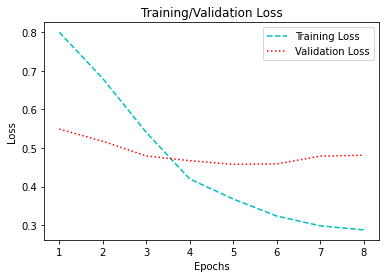

In [ ]:

data1 = [d['Training Loss'] for d in training_stats if 'Training Loss' in d]
data2 = [d['Valid. Loss'] for d in training_stats if 'Valid. Loss' in d]
epochs = [1, 2, 3, 4, 5, 6 ,7 ,8]

plt.plot(epochs, data1, '--c', label="Training Loss") 
plt.plot(epochs, data2, ':r', label="Validation Loss")
plt.title("Training/Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Load test data to perform decoding

Test the geneartor with different encoding algorithm

Define Decoding Functions

In [ ]:
# Greedy
def gready(input_ids):
  greedy_output = model.generate(input_ids, max_length=75)
  return tokenizer.decode(greedy_output[0], skip_special_tokens=True)

# Beam
def beam(input_ids):
  beam_output = model.generate(
    input_ids, 
    max_length=75, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    early_stopping=True
)
  return tokenizer.decode(beam_output[0], skip_special_tokens=True)
# Top K Sampling
def top_k_sampling(input_ids):
  sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=75, 
    top_k=50
)
  return tokenizer.decode(sample_output[0], skip_special_tokens=True)

# Top P Sampling
def top_p_sampling(input_ids):
  sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=75, 
    top_p=0.92, 
    top_k=0
)
  return tokenizer.decode(sample_output[0], skip_special_tokens=True)

# Top K+P Sampling
def top_k_p_sampling(input_ids):
  sample_outputs = model.generate(
    input_ids,
    do_sample=True, 
    max_length=75, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)
  sampling_outputs = []
  for i, sample_output in enumerate(sample_outputs):
    sampling_outputs.append(tokenizer.decode(sample_output, skip_special_tokens=True))
  return sampling_outputs

In [ ]:
# Define split function to just select the first 3 words of the test data
def split_text_in_smaller_size(num, text):
  word_t = text.split()
  return (" ".join(word_t[0:num]))

Perform Decoding

In [ ]:
test_data = []
texts = list(texts)
for i in range(len(texts)):
  test_data.append(split_text_in_smaller_size(3, texts[i]))

output_dic_list = []
for i in range(len(test_data)):
  input_ids = tokenizer.encode(test_data[i], return_tensors='pt').to(device)
  value = {
      'greedy': gready(input_ids),
      'beam': beam(input_ids),
      'top_k': top_k_sampling(input_ids),
      'top_p': top_p_sampling(input_ids),
      'top_k_p': top_k_p_sampling(input_ids) 
  }
  output_dic_list.append(value)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [ ]:
# Save the generated dictionary in dataframe
df_deocded_output = pd.DataFrame.from_dict(output_dic_list)

In [ ]:
# Save the result for future evaluation
df_deocded_output.to_csv('aug.csv',index=False)

Perplexity Calculation

In [ ]:
# Define Perplexity Function
def calculate_perplexity(data):
  ppl = []
  for i in range(len(data)):
    input_ids = tokenizer.encode(data[i], return_tensors='pt').to(device)
    input_ids = input_ids[0]
    labels = input_ids[0]

    with torch.no_grad():
      outputs  = model(b_input_ids, labels=b_labels)
      loss = outputs[0]
    a = np.exp(loss.cpu())
    ppl.append(a)
  return ppl


In [ ]:
# Calulate Preplexity of each decoding methods
data = df_deocded_output['greedy']
ppl_greedy = calculate_perplexity(df_deocded_output['greedy'])
ppl_beam = calculate_perplexity(df_deocded_output['beam'])
ppl_top_k = calculate_perplexity(df_deocded_output['top_k'])
ppl_top_p = calculate_perplexity(df_deocded_output['top_p'])

In [ ]:
print(np.mean(ppl_greedy))
print(np.mean(ppl_beam))
print(np.mean(ppl_top_k))
print(np.mean(ppl_top_p))

1.233304
1.2612373
1.2317014
1.227471
